In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2024-05-17 02:24:07'

In [2]:
import mysql.connector
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',

    })


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


In [5]:
class DbAccessor:
    def __init__(self, db_name, local=False, rlaidb=False, gc=False, gc2=False):
        try:
            if local:
                    self.conn = mysql.connector.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif rlaidb:
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['rlaidbpswd'],
                                            host='198.168.186.104',
                                            database=db_name)

            elif gc:
                self.conn = mysql.connector.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mysql.connector.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3306,
                                            database=db_name)
        except mysql.connector.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def tables(self):
        return pd.read_sql('show tables', self.conn)
    
    def runs(self):
        return pd.read_sql('select * from runs', self.conn)
    
    def q(self, query):
        return pd.read_sql(query, self.conn)

In [6]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)

In [7]:
def conditions_to_str(conditions):
    c_str = ""
    for i, c in enumerate(conditions):
        c_str += str(c[0]) + '=' + str(c[1])
        if i != len(conditions) - 1:
            c_str += " and "
    return c_str

In [8]:
def get_best_hypers(db, swept_parameters, conditions=[('agent_actor_policy_policy', "'gaussian'")], ranking_column="auc100", prioritize_finished_seeds=True):
    sweep_results = db.q(
        f'select {swept_parameters}, \
        avg({ranking_column}), \
        std({ranking_column})/sqrt(count(*)), \
        count(*) \
        as finished_seeds from summary join runs \
        where summary.run=runs.run \
        and {conditions_to_str(conditions)} \
        group by {swept_parameters} \
        order by avg({ranking_column}) desc')
    best_params = list(zip(swept_parameters.split(','), sweep_results.values[0]))
    best_params += conditions
    #completed_runs = db.q(f'select count(*)/1000 as completed_runs from returns join runs where runs.run=returns.run and {conditions_to_str(best_params)} and {conditions}')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(sweep_results), display("best_hypers: "), display(best_params)#, display(completed_runs)
    return best_params

In [9]:
db1 = DbAccessor('hshah1_332_sac_best', rlaidb=True)
db1.runs()

,agent_actor_optimizer_name,agent_actor_optimizer_lr,agent_actor_optimizer_critic_lr_multiplier,agent_actor_optimizer_weight_decay,agent_actor_optimizer_betas,agent_actor_optimizer_eps,agent_actor_policy_policy,agent_actor_policy_mean_init,agent_actor_policy_shape_init,agent_actor_policy_hidden_dim,...,run,db_prefix,db_name,seed,steps,learning_starts,evaluation_steps,evaluation_episodes,n_threads,device
0,Adam,0.001000,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,0.0,hshah1,332_sac_best,10.0,300000.0,0.0,1000.0,1.0,1.0,cpu
1,Adam,0.001000,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,1.0,hshah1,332_sac_best,11.0,300000.0,0.0,1000.0,1.0,1.0,cpu
2,Adam,0.001000,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,2.0,hshah1,332_sac_best,12.0,300000.0,0.0,1000.0,1.0,1.0,cpu
3,Adam,0.001000,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,3.0,hshah1,332_sac_best,13.0,300000.0,0.0,1000.0,1.0,1.0,cpu
4,Adam,0.001000,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,q_gaussian,0.0,1.0,64.0,...,4.0,hshah1,332_sac_best,14.0,300000.0,0.0,1000.0,1.0,1.0,cpu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Adam,0.000001,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,student,0.0,1.0,64.0,...,1425.0,hshah1,332_sac_best,35.0,300000.0,0.0,1000.0,1.0,1.0,cpu
296,Adam,0.000001,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,student,0.0,1.0,64.0,...,1426.0,hshah1,332_sac_best,36.0,300000.0,0.0,1000.0,1.0,1.0,cpu
297,Adam,0.000001,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,student,0.0,1.0,64.0,...,1427.0,hshah1,332_sac_best,37.0,300000.0,0.0,1000.0,1.0,1.0,cpu
298,Adam,0.000001,0.1,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,student,0.0,1.0,64.0,...,1428.0,hshah1,332_sac_best,38.0,300000.0,0.0,1000.0,1.0,1.0,cpu


agent_actor_policy_policy='beta' and env_name='Pendulum-v1'
agent_actor_policy_policy='gaussian' and env_name='Pendulum-v1'
agent_actor_policy_policy='q_gaussian' and env_name='Pendulum-v1'
agent_actor_policy_policy='student' and env_name='Pendulum-v1'
agent_actor_policy_policy='heavytailed_gaussian' and env_name='Pendulum-v1'


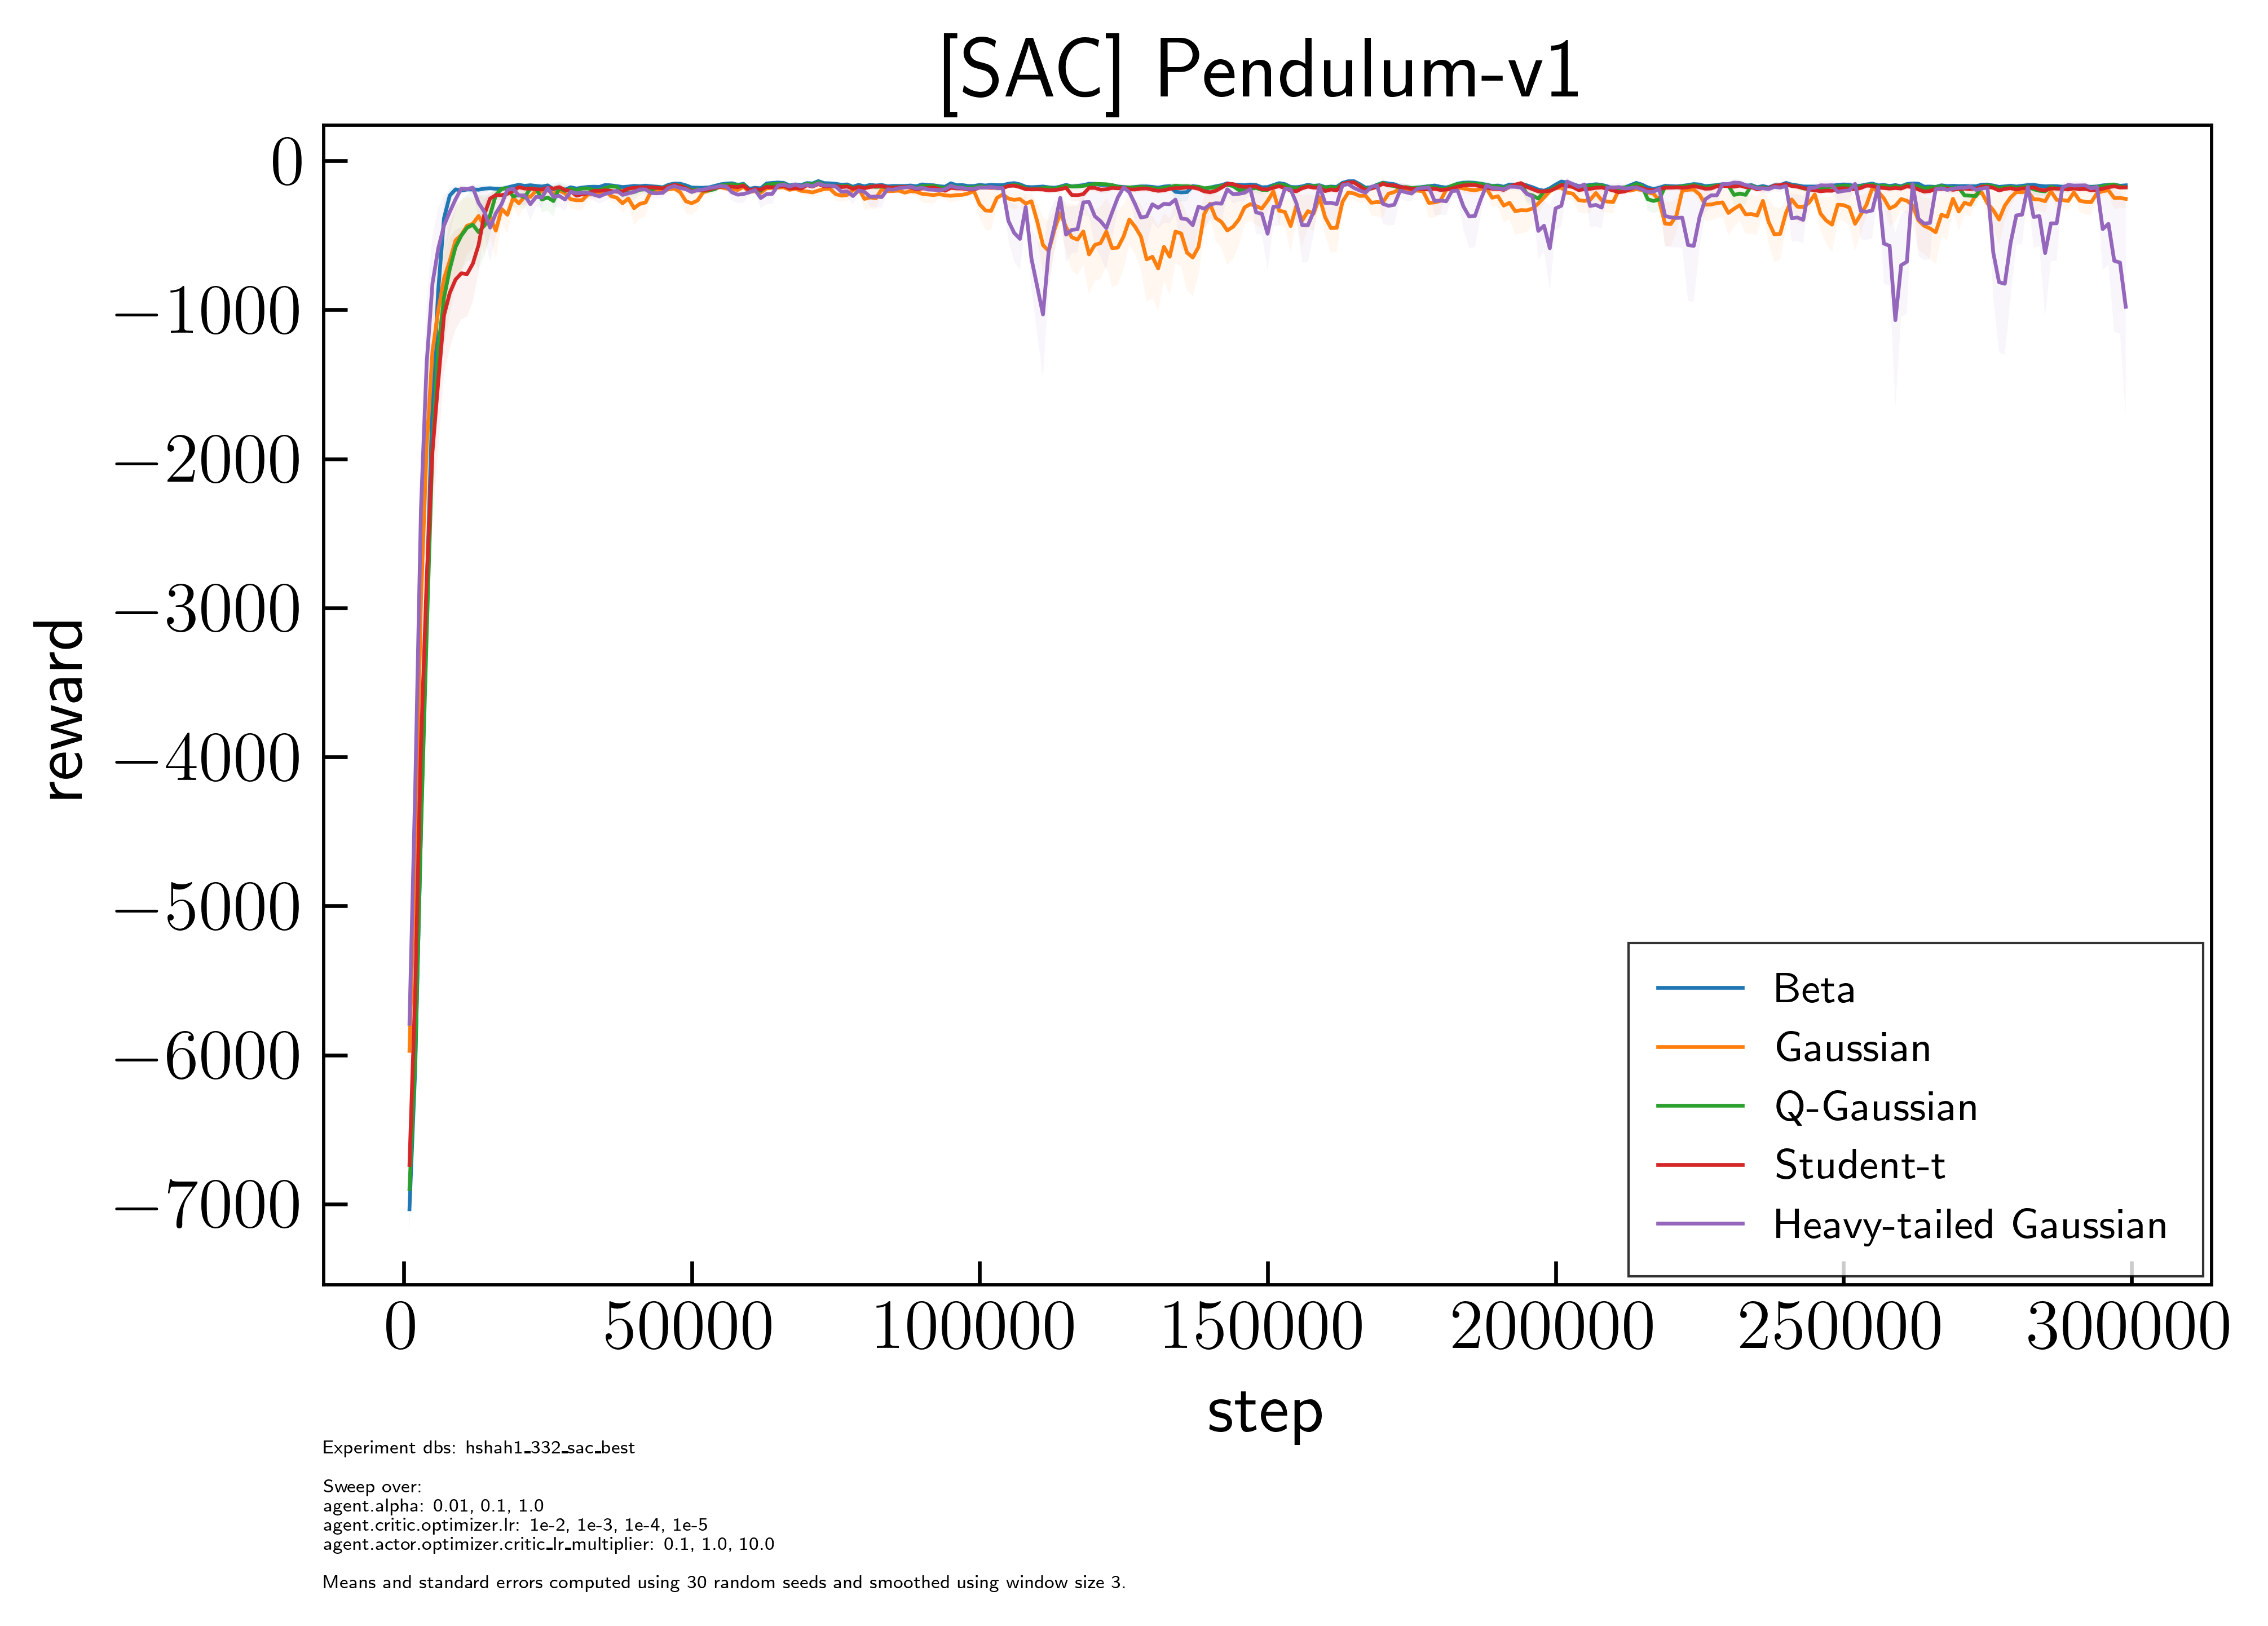

In [14]:
fig, ax = plt.subplots(figsize=(7.2, 4.45), dpi=600)
#plt.figure(figsize=(7.2/2, 4.45/2), dpi=300)
plt.title("[SAC] Pendulum-v1")
plt.xlabel("step")
plt.ylabel(f'reward')
moving_avg_window_size = 3
individual_moving_avg_window_size = 1

err_alpha = 0.06
lwidth = 0.8
nseeds=30
xlim=100000
start_idx = 1
color_idx = 0

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'beta'"), ('env_name', "'Pendulum-v1'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Beta')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'gaussian'"), ('env_name', "'Pendulum-v1'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'q_gaussian'"), ('env_name', "'Pendulum-v1'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Q-Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'student'"), ('env_name', "'Pendulum-v1'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Student-t')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'heavytailed_gaussian'"), ('env_name', "'Pendulum-v1'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Heavy-tailed Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), prop={'size': 9}, loc=4)

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_edgecolor('black')

frame.set_boxstyle('Square')


notes = f'Experiment dbs: hshah1_332_sac_best \n ' \
        f'\nSweep over:\n\t agent.alpha: 0.01, 0.1, 1.0\n'\
        '\tagent.critic.optimizer.lr: 1e-2, 1e-3, 1e-4, 1e-5\n'\
        '\tagent.actor.optimizer.critic_lr_multiplier: 0.1, 1.0, 10.0\n'\
        +f'\nMeans and standard errors computed using {nseeds} random seeds and smoothed using window size {moving_avg_window_size}. '
ax.annotate(notes,
            xy = (0.0, -0.2),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=4)
figname = '119a'
#plt.savefig(f'figures/{figname}.svg', bbox_inches='tight', transparent=False)
plt.savefig(f'figures/{figname}.png', bbox_inches='tight', transparent=False)

agent_actor_policy_policy='beta' and env_name='AcrobotContinuous'
agent_actor_policy_policy='gaussian' and env_name='AcrobotContinuous'
agent_actor_policy_policy='q_gaussian' and env_name='AcrobotContinuous'
agent_actor_policy_policy='student' and env_name='AcrobotContinuous'
agent_actor_policy_policy='heavytailed_gaussian' and env_name='AcrobotContinuous'


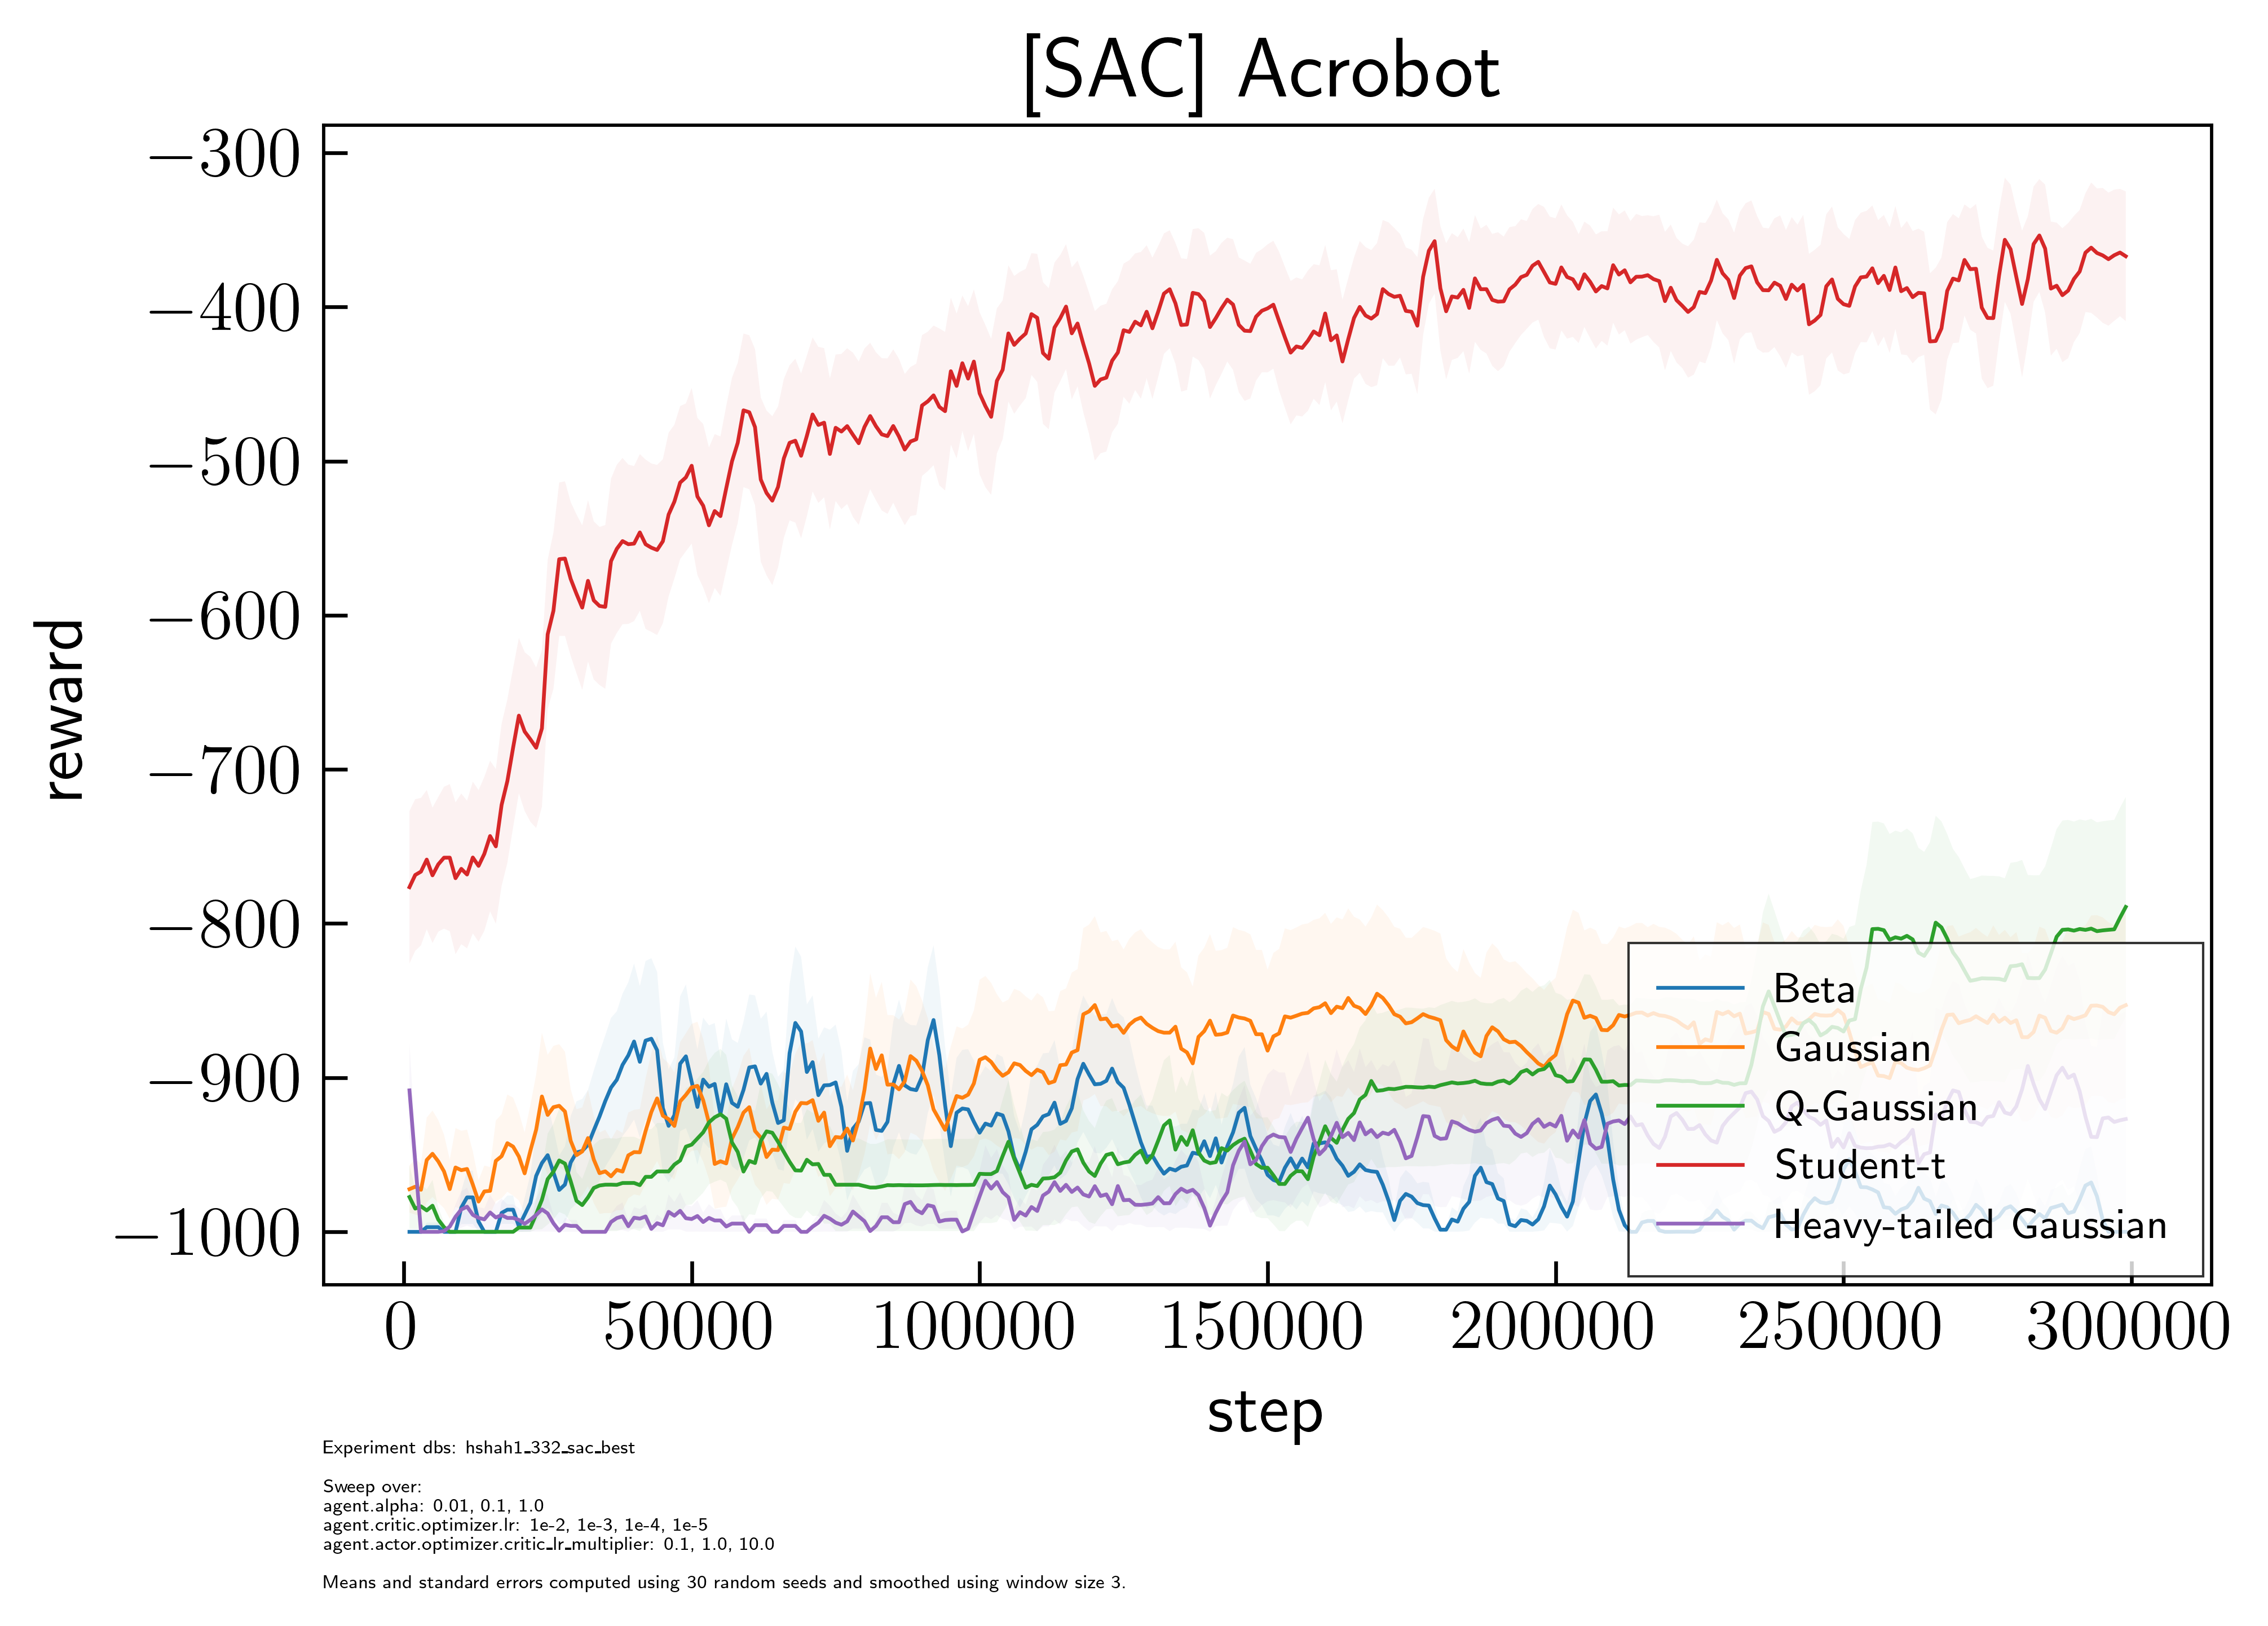

In [11]:
fig, ax = plt.subplots(figsize=(7.2, 4.45), dpi=600)
#plt.figure(figsize=(7.2/2, 4.45/2), dpi=300)
plt.title("[SAC] Acrobot")
plt.xlabel("step")
plt.ylabel(f'reward')
moving_avg_window_size = 3
individual_moving_avg_window_size = 1

err_alpha = 0.06
lwidth = 0.8
nseeds=30
xlim=100000
start_idx = 1
color_idx = 0

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'beta'"), ('env_name', "'AcrobotContinuous'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Beta')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'gaussian'"), ('env_name', "'AcrobotContinuous'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'q_gaussian'"), ('env_name', "'AcrobotContinuous'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Q-Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'student'"), ('env_name', "'AcrobotContinuous'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Student-t')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1

db = db1
print(best_p := conditions_to_str([('agent_actor_policy_policy', "'heavytailed_gaussian'"), ('env_name', "'AcrobotContinuous'")]))
v = db.q(f'select step, avg(reward), std(reward)/sqrt(count(*)), count(*) from runs join returns where returns.run = runs.run and {best_p} group by step limit {xlim}').values
mean = moving_avg(v[start_idx:,1],moving_avg_window_size) #test
std_err = moving_avg(v[start_idx:,2],moving_avg_window_size)
plt.plot(v[start_idx:,0], mean, color=colors[color_idx], linewidth=lwidth, linestyle='-', label=r'Heavy-tailed Gaussian')
plt.fill_between(v[start_idx:,0], mean+std_err, mean-std_err, alpha=err_alpha, color=colors[color_idx], edgecolor=None )

color_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), prop={'size': 9}, loc=4)

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_edgecolor('black')

frame.set_boxstyle('Square')


notes = f'Experiment dbs: hshah1_332_sac_best \n ' \
        f'\nSweep over:\n\t agent.alpha: 0.01, 0.1, 1.0\n'\
        '\tagent.critic.optimizer.lr: 1e-2, 1e-3, 1e-4, 1e-5\n'\
        '\tagent.actor.optimizer.critic_lr_multiplier: 0.1, 1.0, 10.0\n'\
        +f'\nMeans and standard errors computed using {nseeds} random seeds and smoothed using window size {moving_avg_window_size}. '
ax.annotate(notes,
            xy = (0.0, -0.2),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=4)
figname = '119b'
#plt.savefig(f'figures/{figname}.svg', bbox_inches='tight', transparent=False)
plt.savefig(f'figures/{figname}.png', bbox_inches='tight', transparent=False)